# INTRODUCCIÓN
### El objetivo de este ejercicio es construir un modelo predictivo utilizando XGBoost para identificar clientes morosos en una base de datos simulada. Se generaron 50,000 registros y se preprocesaron los datos, incluyendo la conversión de variables categóricas y el escalado de características numéricas. El modelo se entrenó y evaluó utilizando GridSearchCV, obteniendo una precisión y un valor de ROC AUC del 50%, lo que indica un rendimiento similar al de una clasificación aleatoria. Se recomienda realizar ajustes adicionales para mejorar el rendimiento del modelo.



#### Codigo


Datos cargados desde el CSV:
   ingresos_mensuales  edad  deudas_totales  numero_tarjetas  \
0                1200    35            5000                2   
1                 800    29            2000                1   
2                1500    40            3000                3   
3                1560    39            5130                2   
4                 758    22            1871                1   

   historial_crediticio  tasa_de_interes  mora_actual  moroso  
0                     0        12.500000            0       0  
1                     1        20.000000            1       1  
2                     2        15.000000            0       0  
3                     0        13.486585            0       1  
4                     1        21.508885            0       1  


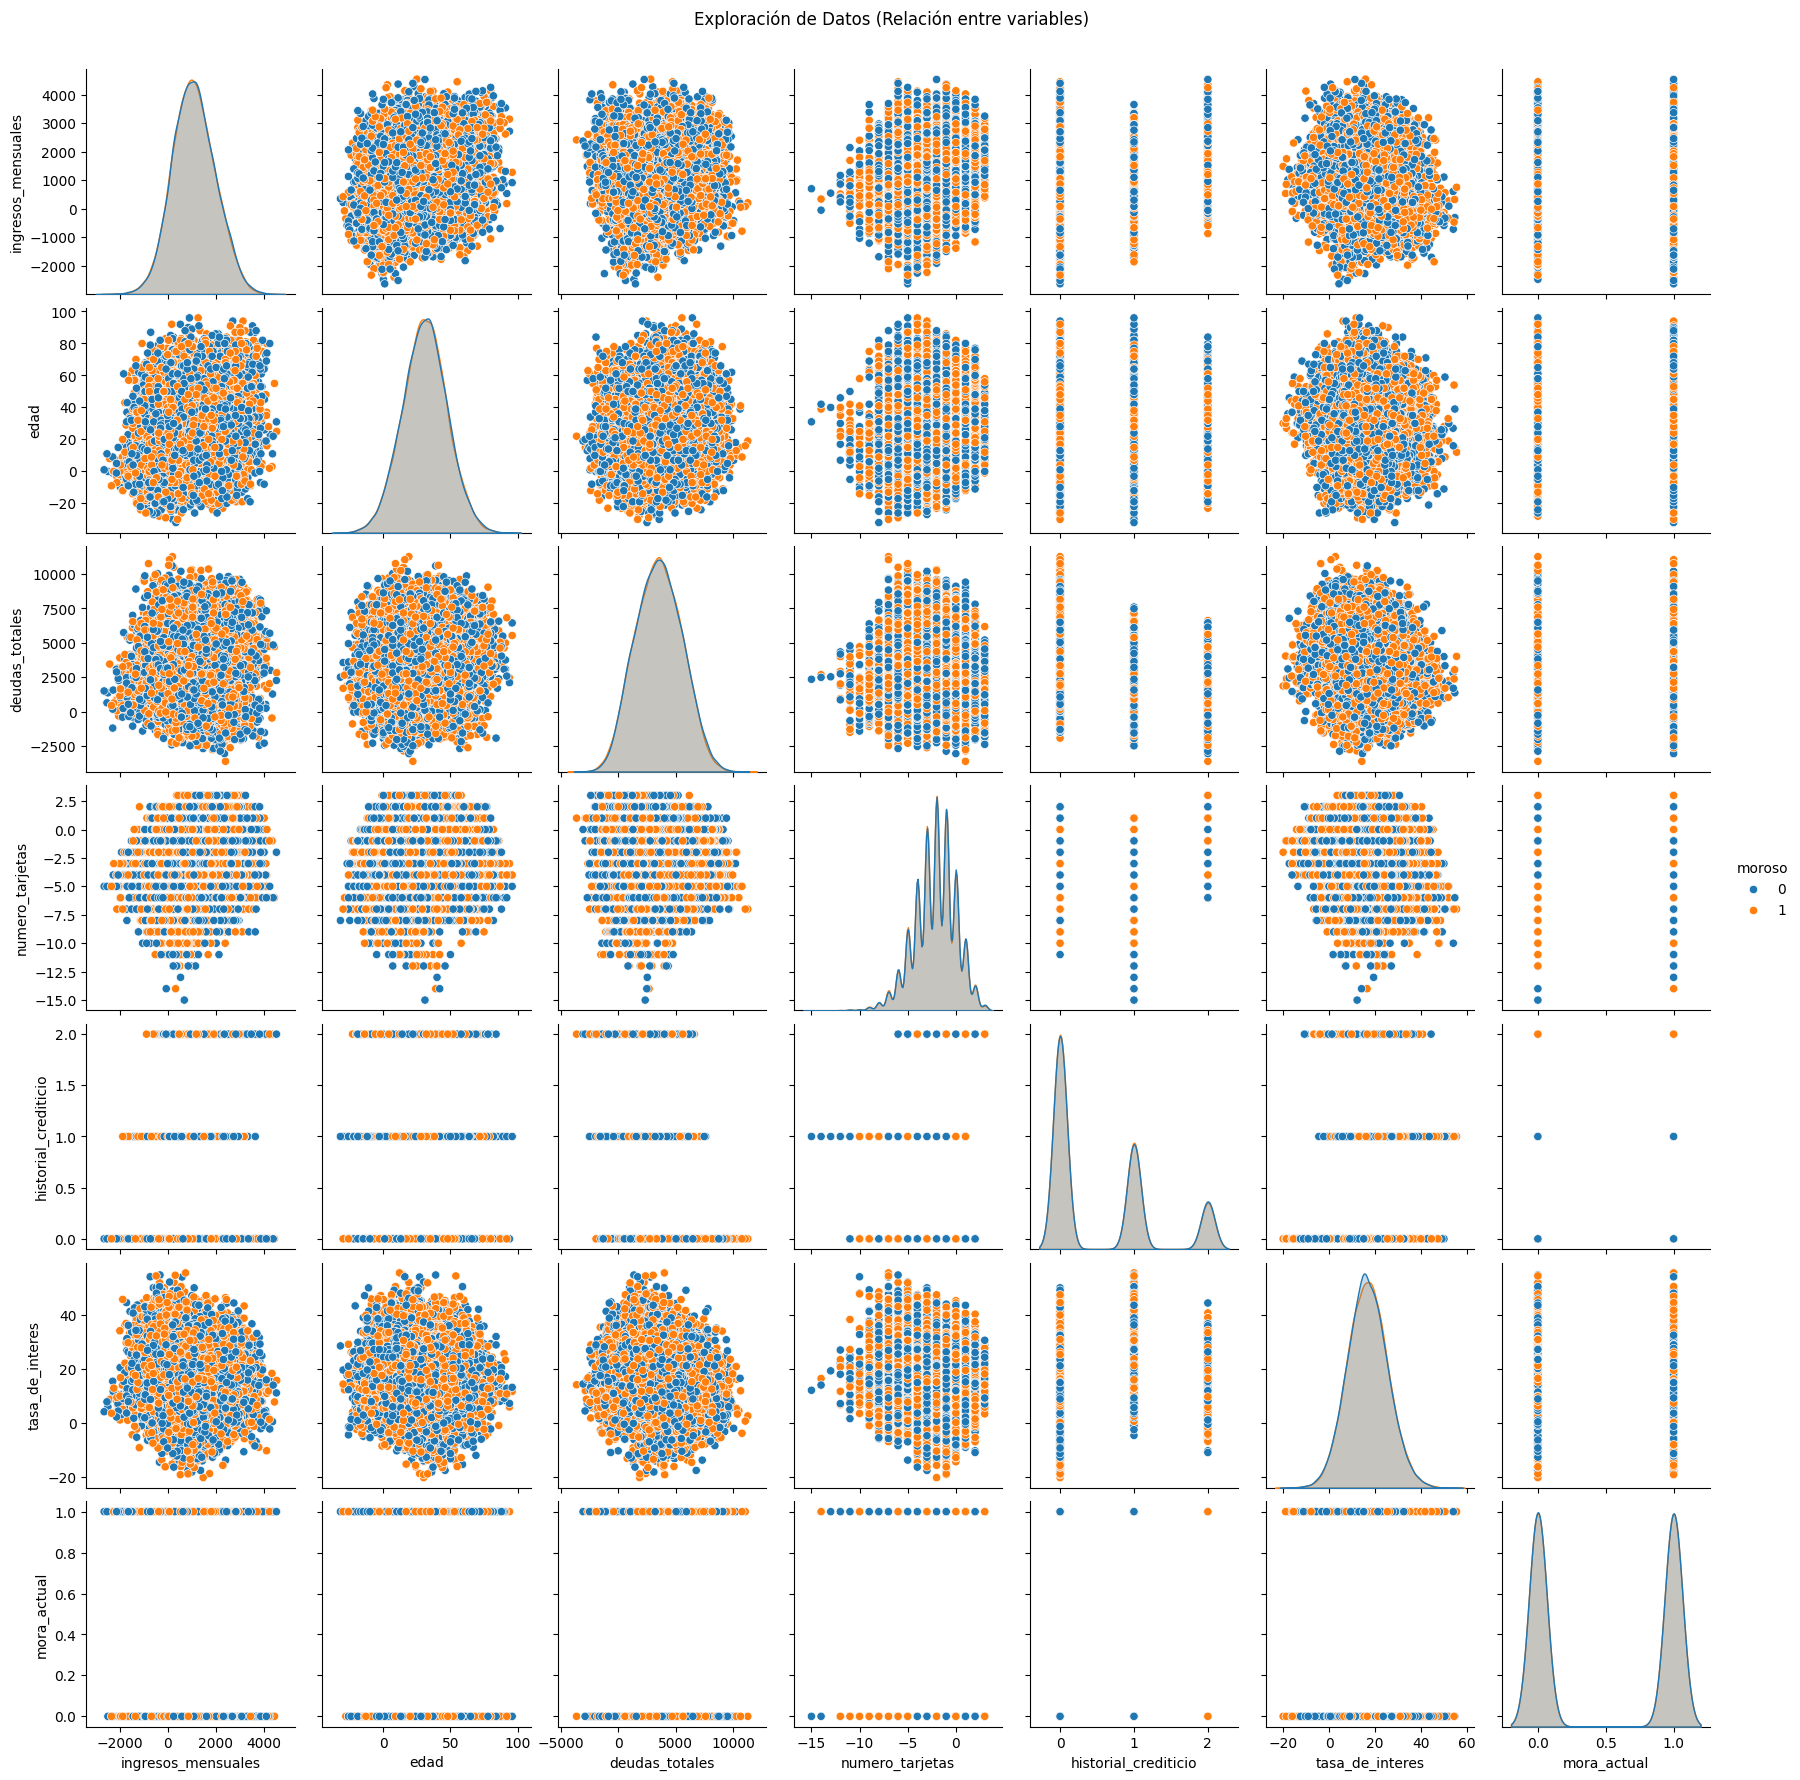

Datos de entrenamiento: (40000, 7), Datos de prueba: (10000, 7)
Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.9}
Precisión: 0.50
ROC AUC: 0.50

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50      5015
           1       0.50      0.49      0.49      4985

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



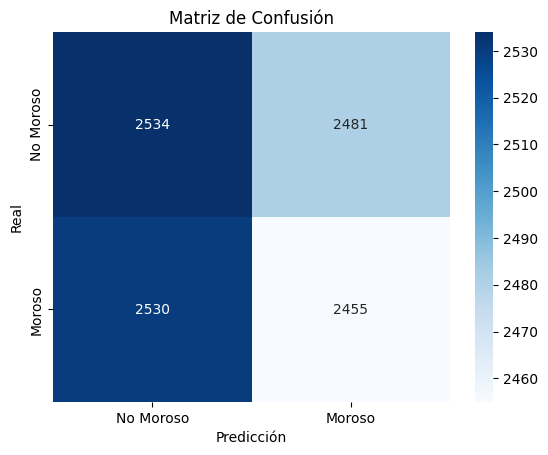

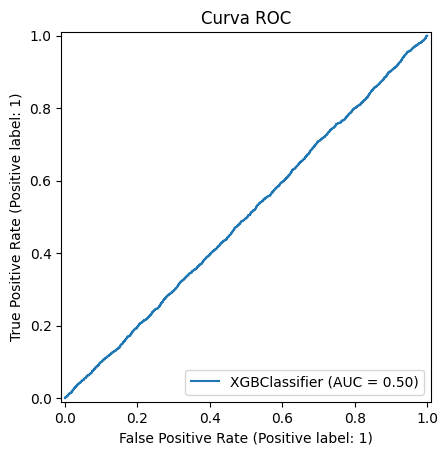

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from xgboost import XGBClassifier
import os

csv_file = 'clientes.csv'

# Crear un DataFrame inicial con los datos base
data = pd.DataFrame({
    'ingresos_mensuales': [1200, 800, 1500],
    'edad': [35, 29, 40],
    'deudas_totales': [5000, 2000, 3000],
    'numero_tarjetas': [2, 1, 3],
    'historial_crediticio': ['Bueno', 'Malo', 'Regular'],
    'tasa_de_interes': [12.5, 20.0, 15.0],
    'mora_actual': [0, 1, 0],
    'moroso': [0, 1, 0]
})

# Generar datos adicionales hasta alcanzar 50,000 registros
np.random.seed(42)
for _ in range(49997):  # Simulación con datos aleatorios para alcanzar 50,000 registros
    new_data = data.sample(n=1).copy()
    new_data['ingresos_mensuales'] += np.random.randint(-500, 500)
    new_data['edad'] += np.random.randint(-10, 10)
    new_data['deudas_totales'] += np.random.randint(-1000, 1000)
    new_data['numero_tarjetas'] += np.random.randint(-1, 1)
    new_data['tasa_de_interes'] += np.random.uniform(-5, 5)
    new_data['mora_actual'] = np.random.randint(0, 2)
    new_data['moroso'] = np.random.randint(0, 2)
    data = pd.concat([data, new_data], ignore_index=True)

# Guardar el DataFrame en un archivo CSV
data.to_csv(csv_file, index=False)

# Leer el archivo CSV como entrada
data = pd.read_csv(csv_file)

# Convertir historial_crediticio a numérico si es categórico
if data['historial_crediticio'].dtype == 'object':
    encoder = LabelEncoder()
    data['historial_crediticio'] = encoder.fit_transform(data['historial_crediticio'])

# Visualización inicial de los datos
print("Datos cargados desde el CSV:")
print(data.head())
sns.pairplot(data, hue="moroso", diag_kind="kde")
plt.suptitle("Exploración de Datos (Relación entre variables)", y=1.02)
plt.show()

# Preprocesamiento de características
X = data.drop(columns=['moroso'])
y = data['moroso']

# Escalado de características numéricas
scaler = StandardScaler()
X[['ingresos_mensuales', 'edad', 'deudas_totales', 'numero_tarjetas', 'tasa_de_interes']] = scaler.fit_transform(
    X[['ingresos_mensuales', 'edad', 'deudas_totales', 'numero_tarjetas', 'tasa_de_interes']]
)

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos
print(f"Datos de entrenamiento: {X_train.shape}, Datos de prueba: {X_test.shape}")

# Configurar y entrenar el modelo con GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 6],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor modelo
print(f"Mejores parámetros: {grid_search.best_params_}")

# Predicciones con el mejor modelo
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Precisión: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
plt.title("Curva ROC")
plt.show()
